# Notebook 01: Sovereign Risk Dashboard (10YR vs. Gold)
#
# **Pair:** 10YR Treasury Futures (/ZB) vs. Gold Futures (/GC)
# **Thesis:** Tracking the breakdown of the classic "safe haven" correlation.
# In a classic risk-off, /ZB (price) and /GC rise together.
# In the new "Sovereign Risk / De-Dollarization" regime, /ZB falls (yields rise)
# while /GC rises, signaling a loss of faith in U.S. debt as a haven.
#
# **Proxies Used:**
# * `/ZB=F` (T-Note Future) -> `TLT` (20+ Yr Treasury ETF for clean price history)
# * `/GC=F` (Gold Future)   -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `DFII10`: 10-Yr Real Yield (TIPS). The #1 driver. Gold (non-yielding) should move inversely to this.
# * `T10YIE`: 10-Yr Breakeven Inflation.
# * `DTWEXBGS`: Trade-Weighted U.S. Dollar Index.

In [1]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [2]:
# Cell 2: API & LLM Configuration (Refactored)
#
# Set up API keys, LLM endpoints, and asset tickers.
# ADDED: Volatility tickers GVZCLS and TYVIXCLS.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["GLD", "TLT"]
FRED_SERIES_IDS = [
    "DFII10", "T10YIE", "DTWEXBGS", # Core Macro Drivers
    "GVZCLS",                       # CBOE Gold Volatility Index
    "VIXCLS"                      # CBOE 10Y Treasury Volatility Index
]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['GLD', 'TLT'] and ['DFII10', 'T10YIE', 'DTWEXBGS', 'GVZCLS', 'VIXCLS']


In [3]:
# Cell 3: Data Collection - yfinance
#
# (No change to this cell, using your provided version)
#
# Fetch historical price data for our ETF proxies (GLD, TLT).
# We only care about the 'Close' which accounts for dividends/splits.
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")

Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_1126580/1623176768.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)


[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker             GLD        TLT
Date                             
2025-10-28  364.380005  92.019997
2025-10-29  363.000000  91.089996
2025-10-30  370.130005  90.559998
2025-10-31  368.119995  90.290001
2025-11-03  368.779999  89.739998


In [4]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            DFII10  T10YIE  DTWEXBGS  GVZCLS  VIXCLS
2025-10-28    1.71    2.28  121.0349   24.03   16.42
2025-10-29    1.78    2.30  120.9290   24.70   16.92
2025-10-30    1.82    2.29  121.6650   24.82   16.91
2025-10-31    1.81    2.30  121.7715   22.66   17.44
2025-11-03     NaN    2.31       NaN     NaN     NaN


In [5]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill weekends/holidays.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (e.g., FRED data on non-market days, or vice-versa)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
                   GLD        TLT  DFII10  T10YIE  DTWEXBGS  GVZCLS  VIXCLS
2025-10-28  364.380005  92.019997    1.71    2.28  121.0349   24.03   16.42
2025-10-29  363.000000  91.089996    1.78    2.30  120.9290   24.70   16.92
2025-10-30  370.130005  90.559998    1.82    2.29  121.6650   24.82   16.91
2025-10-31  368.119995  90.290001    1.81    2.30  121.7715   22.66   17.44
2025-11-03  368.779999  89.739998    1.81    2.31  121.7715   22.66   17.44


In [6]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
# A Z-Score tells us how many standard deviations a value is from its mean.
# This is critical for comparing yields (e.g., 4.5) to prices (e.g., 200).

try:
    df_normalized = df.apply(zscore)
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                GLD           TLT        DFII10        T10YIE      DTWEXBGS        GVZCLS        VIXCLS
count  1.304000e+03  1.304000e+03  1.304000e+03  1.304000e+03  1.304000e+03  1.304000e+03  1.304000e+03
mean  -8.718316e-17  4.359158e-17  8.718316e-17 -1.089789e-15  1.743663e-16  1.852642e-16  5.230989e-16
std    1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00
min   -1.020322e+00 -1.408296e+00 -1.719877e+00 -3.810126e+00 -1.975864e+00 -2.308843e+00 -1.441587e+00
25%   -6.706041e-01 -7.772295e-01 -1.259620e+00 -4.305928e-01 -8.772495e-01 -5.801722e-01 -7.196426e-01
50%   -4.628540e-01 -4.605147e-01  5.023317e-01 -4.903266e-02  1.907921e-01 -1.093378e-01 -2.058605e-01
75%    4.093211e-01  1.068701e+00  8.348520e-01  3.870361e-01  6.362890e-01  5.144536e-01  5.307497e-01
max    3.832383e+00  2.221829e+00  1.289026e+00  3.712060e+00  2.191424e+00  5.402244e+00  6.216889e+00


In [7]:
# Cell 7: Feature Engineering - Ratios & Spreads (Refactored)
#
# (No functional change, but adding new metrics in subsequent cells)
#
# * Ratio: The price of GLD divided by the price of TLT. A rising ratio
#     means Gold is outperforming Treasuries (our thesis).
# * Spread (Normalized): The normalized Z-score of GLD minus the
#     normalized Z-score of TLT. This shows the *magnitude* of the divergence.

try:
    # 1. Price Ratio (The Core Signal)
    df['GLD_TLT_Ratio'] = df['GLD'] / df['TLT']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['GLD_TLT_Spread_Norm'] = df_normalized['GLD'] - df_normalized['TLT']
    
    # 3. Causal Spread (Gold vs. Real Yields)
    # This *should* be negative. If it turns positive, the relationship is broken.
    df['GLD_DFII10_Spread_Norm'] = df_normalized['GLD'] - df_normalized['DFII10']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['GLD_TLT_Ratio', 'GLD_TLT_Spread_Norm', 'GLD_DFII10_Spread_Norm']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            GLD_TLT_Ratio  GLD_TLT_Spread_Norm  GLD_DFII10_Spread_Norm
2025-10-28       3.959792             3.585057                2.453466
2025-10-29       3.985070             3.611939                2.370111
2025-10-30       4.087125             3.779753                2.475014
2025-10-31       4.077085             3.756557                2.444406
2025-11-03       4.109427             3.800889                2.457120


In [8]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# (No change to this cell, but HV calculation is added next)
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of GLD and TLT.
# This directly quantifies the "correlation breakdown" over time.

try:
    # First, get daily percentage returns
    df['GLD_pct'] = df['GLD'].pct_change()
    df['TLT_pct'] = df['TLT'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['GLD_pct'].rolling(window=30).corr(df['TLT_pct'])
    df['Corr_90D'] = df['GLD_pct'].rolling(window=90).corr(df['TLT_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-28 -0.000802  0.178167
2025-10-29  0.011054  0.183667
2025-10-30 -0.050887  0.167758
2025-10-31 -0.033744  0.154827
2025-11-03 -0.011075  0.143879


In [9]:
# Cell 8a: Feature Engineering - Historical Volatility (NEW)
#
# Calculate 30-day Historical (Realized) Volatility (HV) for our assets.
# This will be compared against Implied Volatility (IV).

try:
    # Calculate 30-day rolling HV (annualized)
    df['GLD_HV_30D'] = df['GLD_pct'].rolling(window=30).std() * np.sqrt(252)
    df['TLT_HV_30D'] = df['TLT_pct'].rolling(window=30).std() * np.sqrt(252)

    print("✅ Cell 8a: Historical Volatility (HV) calculated.")
    print(df[['GLD_HV_30D', 'TLT_HV_30D']].tail())

except Exception as e:
    print(f"❌ Cell 8a: HV calculation failed: {e}")

✅ Cell 8a: Historical Volatility (HV) calculated.
            GLD_HV_30D  TLT_HV_30D
2025-10-28    0.296529    0.083827
2025-10-29    0.295567    0.089101
2025-10-30    0.298865    0.085227
2025-10-31    0.299138    0.085563
2025-11-03    0.296012    0.086922


In [10]:
# Cell 8b: Feature Engineering - IV Rank (NEW)
#
# Calculate the 1-year (252-day) Implied Volatility Rank (IVR).
# This tells us if the current IV is "high" or "low" relative to its own history.
# IVR = 100 * (Current IV - 52wk Low) / (52wk High - 52wk Low)

try:
    # Calculate 252-day rolling min/max for Gold Vol
    df['GVZ_min_252D'] = df['GVZCLS'].rolling(window=252).min()
    df['GVZ_max_252D'] = df['GVZCLS'].rolling(window=252).max()
    
    # Calculate 252-day rolling min/max for Treasury Vol
    df['TYVIX_min_252D'] = df['VIXCLS'].rolling(window=252).min()
    df['TYVIX_max_252D'] = df['VIXCLS'].rolling(window=252).max()
    
    # Calculate IV Rank for both
    df['GVZ_IVR_252D'] = 100 * (df['GVZCLS'] - df['GVZ_min_252D']) / (df['GVZ_max_252D'] - df['GVZ_min_252D'])
    df['TYVIX_IVR_252D'] = 100 * (df['VIXCLS'] - df['TYVIX_min_252D']) / (df['TYVIX_max_252D'] - df['TYVIX_min_252D'])

    print("✅ Cell 8b: Implied Volatility Rank (IVR) calculated.")
    print(df[['GVZCLS', 'GVZ_IVR_252D', 'VIXCLS', 'TYVIX_IVR_252D']].tail())

except Exception as e:
    print(f"❌ Cell 8b: IV Rank calculation failed: {e}")

✅ Cell 8b: Implied Volatility Rank (IVR) calculated.
            GVZCLS  GVZ_IVR_252D  VIXCLS  TYVIX_IVR_252D
2025-10-28   24.03     52.159650   16.42        9.226491
2025-10-29   24.70     55.822854   16.92       10.490394
2025-10-30   24.82     56.478950   16.91       10.465116
2025-10-31   22.66     44.669218   17.44       11.804853
2025-11-03   22.66     44.669218   17.44       11.804853


In [11]:
# Cell 8c: Feature Engineering - VRP & Signal Velocity (NEW)
#
# Calculate the Volatility Risk Premium (VRP) and Signal Velocity.
# VRP = Implied Vol (IV) - Historical Vol (HV).
#     Positive VRP = Options are "expensive" (Good for selling premium).
#     Negative VRP = Options are "cheap" (Good for buying vega).
#
# Signal Velocity = 5-day change in the normalized spread.
#     This shows if the thematic signal is accelerating.

try:
    # 1. Volatility Risk Premium (VRP)
    df['GLD_VRP'] = df['GVZCLS'] - df['GLD_HV_30D']
    df['TLT_VRP'] = df['VIXCLS'] - df['TLT_HV_30D']
    
    # 2. Signal Velocity
    df['Signal_Velocity_5D'] = df['GLD_TLT_Spread_Norm'].diff(5)

    print("✅ Cell 8c: VRP and Signal Velocity calculated.")
    print(df[['GLD_VRP', 'TLT_VRP', 'Signal_Velocity_5D']].tail())
    
    # Drop NaNs created by all the new rolling windows to clean the final df
    df = df.dropna()

except Exception as e:
    print(f"❌ Cell 8c: VRP/Velocity calculation failed: {e}")

✅ Cell 8c: VRP and Signal Velocity calculated.
              GLD_VRP    TLT_VRP  Signal_Velocity_5D
2025-10-28  23.733471  16.336173           -0.248870
2025-10-29  24.404433  16.830899           -0.219309
2025-10-30  24.521135  16.824773           -0.116801
2025-10-31  22.360862  17.354437           -0.113233
2025-11-03  22.363988  17.353078            0.151374


Plotting Cell 9: Core Thesis...


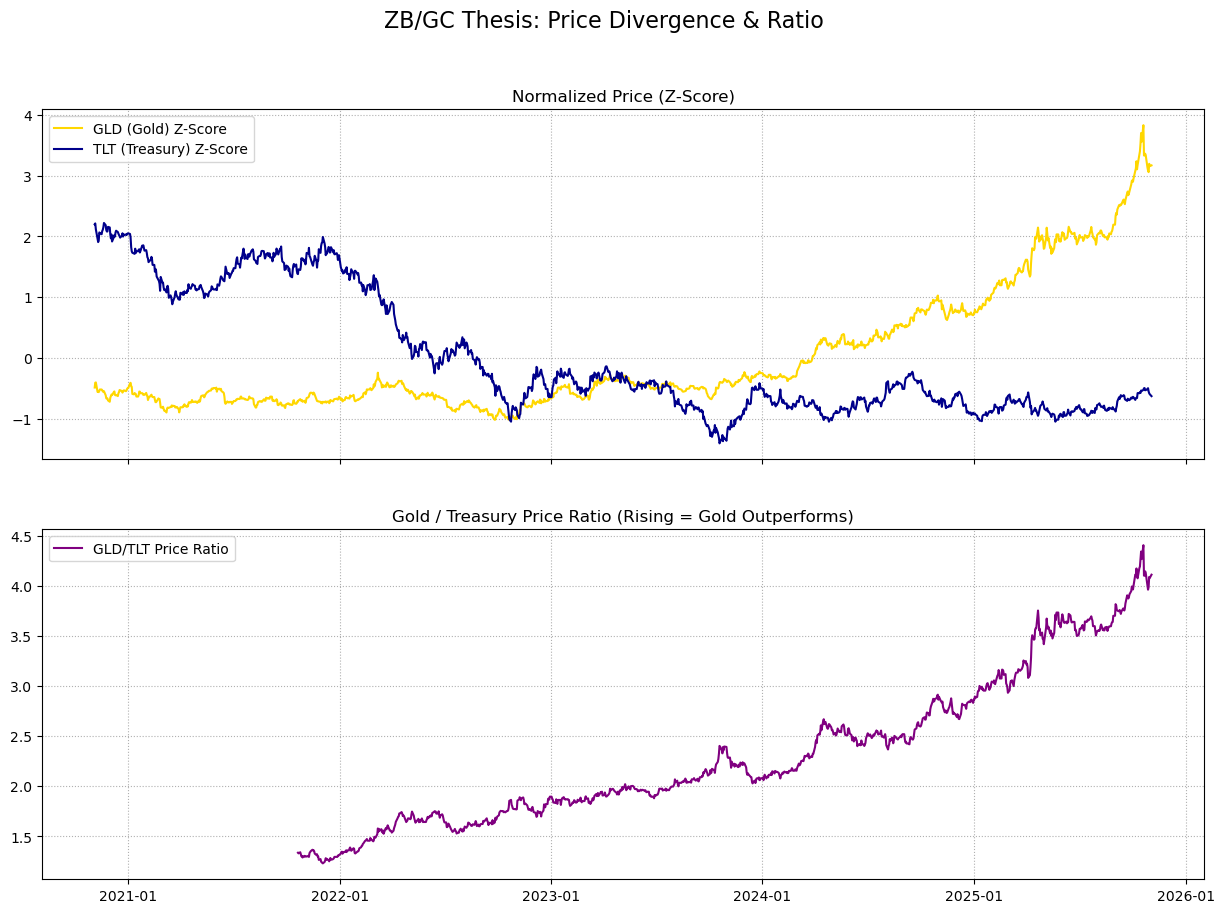

In [12]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of GLD vs. TLT.
# Plot 2: The GLD/TLT Ratio.
#
# This chart shows *what* is happening. Are they diverging? Is the ratio
# in a clear uptrend?

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('ZB/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['TLT'], label='TLT (Treasury) Z-Score', color='darkblue')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['GLD_TLT_Ratio'], label='GLD/TLT Price Ratio', color='purple')
    ax2.set_title('Gold / Treasury Price Ratio (Rising = Gold Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver...


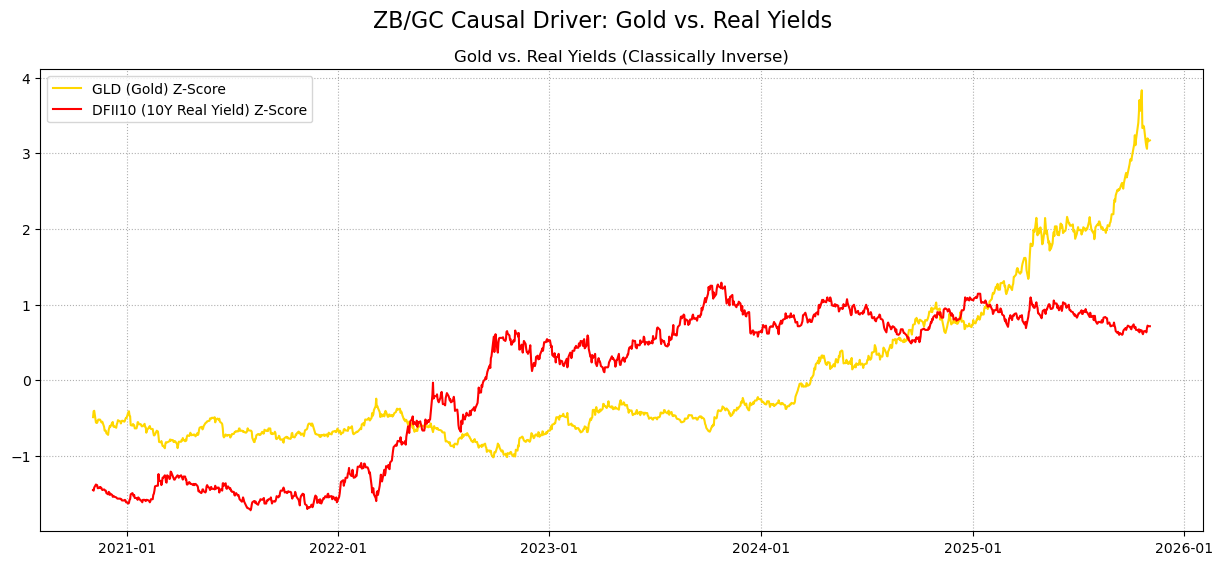

In [13]:
# Cell 10: Visualization - Causal Driver (Real Yields)
#
# Plot 1: Normalized prices of GLD vs. 10Y Real Yield (DFII10).
#
# This chart shows *why* it's happening.
# Classic relationship: INVERSE. GLD (gold) rises, DFII10 (real yield) falls.
# If they both rise together, the "safe haven" model is broken.

try:
    print("Plotting Cell 10: Causal Driver...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('ZB/GC Causal Driver: Gold vs. Real Yields', fontsize=16)

    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['DFII10'], label='DFII10 (10Y Real Yield) Z-Score', color='red')
    ax1.set_title('Gold vs. Real Yields (Classically Inverse)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


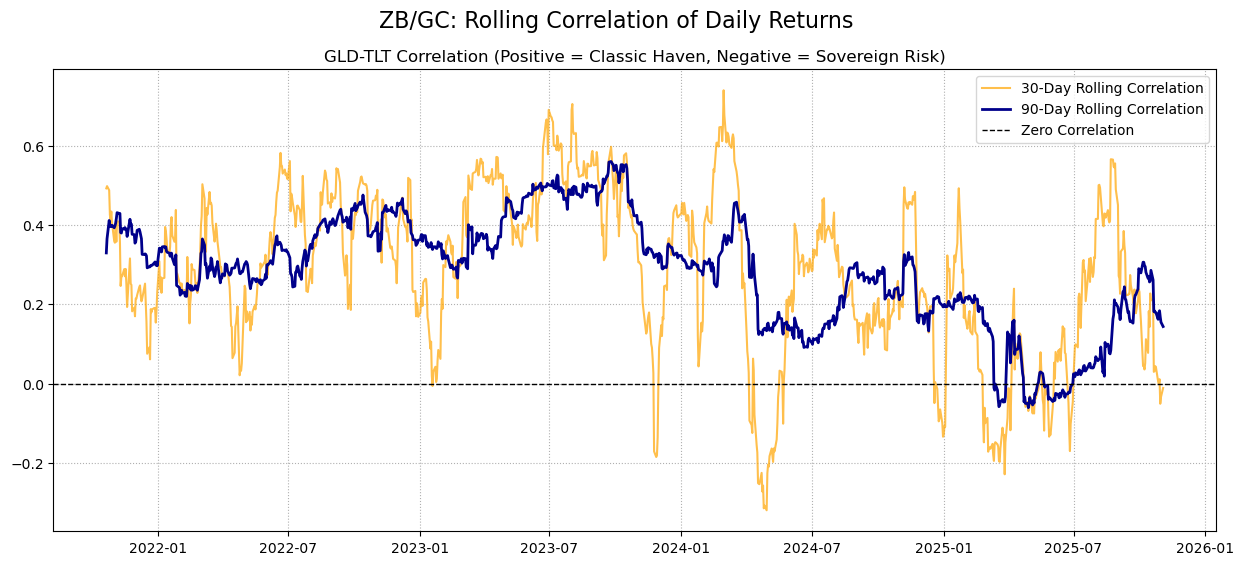

In [14]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the thesis. A positive correlation (e.g., +0.5)
# means they act as classic risk-off partners. A negative correlation
# (e.g., -0.3) means the "Sovereign Risk" thesis is in play.

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('ZB/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('GLD-TLT Correlation (Positive = Classic Haven, Negative = Sovereign Risk)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

Plotting Cell 11a: Volatility Dashboard...


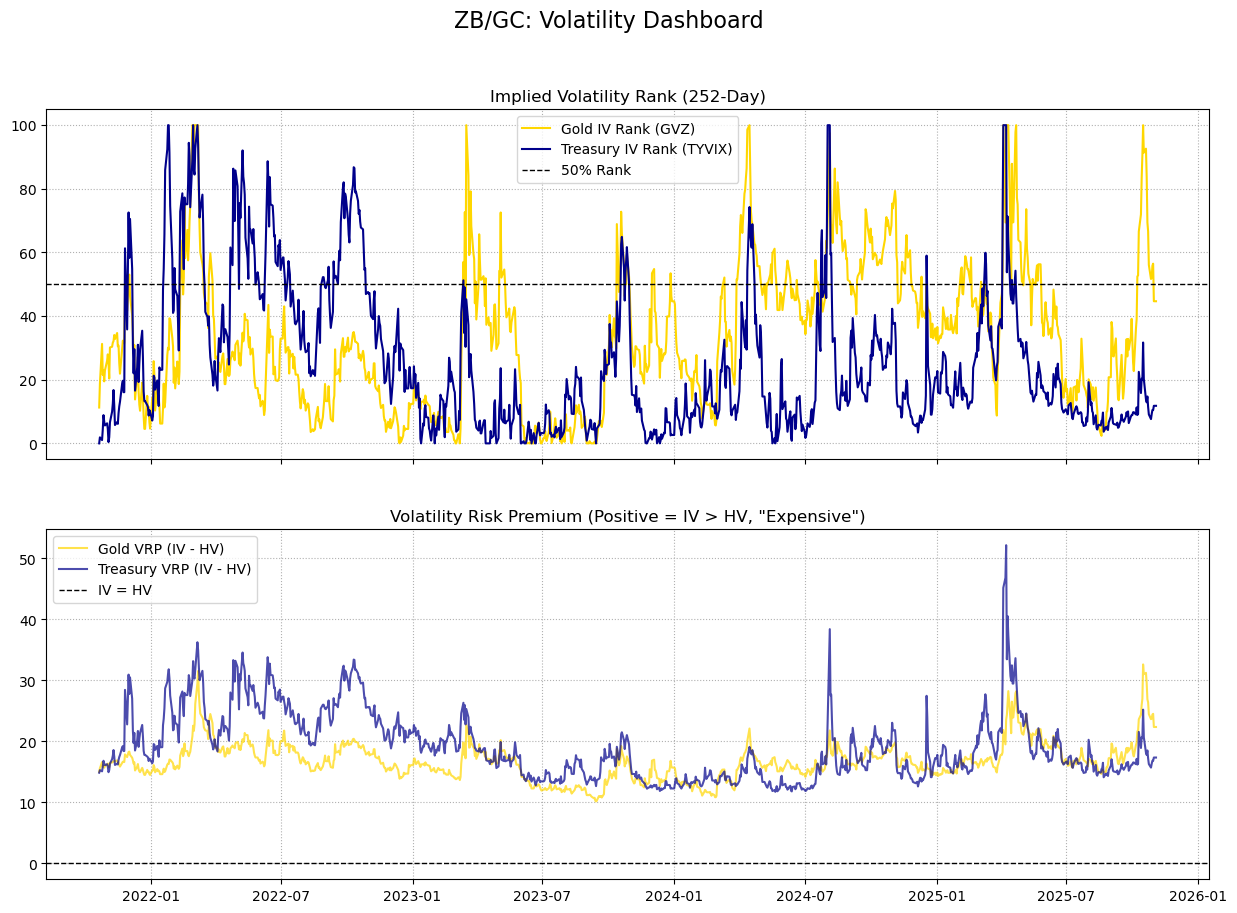

In [15]:
# Cell 11a: Visualization - Volatility Dashboard (NEW)
#
# Plot the IV Rank and the Volatility Risk Premium (VRP).
# This chart tells us *when* to put on a trade and *what kind*.

try:
    print("Plotting Cell 11a: Volatility Dashboard...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('ZB/GC: Volatility Dashboard', fontsize=16)

    # Plot 1: IV Rank (Tells you if vol is "high" or "low")
    ax1.plot(df.index, df['GVZ_IVR_252D'], label='Gold IV Rank (GVZ)', color='gold')
    ax1.plot(df.index, df['TYVIX_IVR_252D'], label='Treasury IV Rank (TYVIX)', color='darkblue')
    ax1.axhline(50, color='black', linestyle='--', linewidth=1, label='50% Rank')
    ax1.set_title('Implied Volatility Rank (252-Day)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Volatility Risk Premium (IV vs HV)
    ax2.plot(df.index, df['GLD_VRP'], label='Gold VRP (IV - HV)', color='gold', alpha=0.7)
    ax2.plot(df.index, df['TLT_VRP'], label='Treasury VRP (IV - HV)', color='darkblue', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='IV = HV')
    ax2.set_title('Volatility Risk Premium (Positive = IV > HV, "Expensive")')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11a: Volatility plotting failed: {e}")

In [16]:
# Cell 12: LLM Analyst Synthesis (Refactored for Reasoning)
#
# This cell is for YOU. It runs the full qualitative analysis and
# outputs a human-readable synthesis. The output is saved to a
# variable for the next cell to parse.

try:
    print("Sending data to LLM for full analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # --- Create Data Summary ---
    macro_summary = f"""
--- MACRO THEME (Pair: ZB/GC) ---
- **Thematic Bias:** Sovereign Risk (GLD outperforming TLT)
- **Signal Strength (Z-Score):** {latest_data['GLD_TLT_Spread_Norm']:.2f}
- **Signal Velocity (5D Change):** {latest_data['Signal_Velocity_5D']:.2f}
- **Regime Type (90D Corr):** {latest_data['Corr_90D']:.3f} (Low/Negative = Trend, High = Range)
"""
    
    target_asset = 'GLD' if latest_data['GLD_TLT_Spread_Norm'] > 0 else 'TLT'
    
    if target_asset == 'GLD':
        vol_summary = f"""
--- VOLATILITY DASHBOARD (Asset: GLD) ---
- **Implied Vol (GVZCLS):** {latest_data['GVZCLS']:.2f}
- **IV Rank (1-Year):** {latest_data['GVZ_IVR_252D']:.1f}%
- **Vol Risk Premium (IV vs HV):** {latest_data['GLD_VRP']:.2f} (Positive = "Expensive", Negative = "Cheap")
"""
    else: # Target is TLT
        vol_summary = f"""
--- VOLATILITY DASHBOARD (Asset: TLT) ---
- **Implied Vol (TYVIXCLS):** {latest_data['TYVIXCLS']:.2f}
- **IV Rank (1-Year):** {latest_data['TYVIX_IVR_252D']:.1f}%
- **Vol Risk Premium (IV vs HV):** {latest_data['TLT_VRP']:.2f} (Positive = "Expensive", Negative = "Cheap")
"""

    # --- Create the LLM Prompt ---
    prompt = f"""
**Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.

**Your Available Strategies:**
* Bull_Put_Spread, Bear_Call_Spread, Iron_Condor (Sell Premium)
* Calendar_Spread, Diagonal_Spread, Double_Diagonal_Spread (Buy Vega)
* No_Trade

**Latest OSINT Data:**
{macro_summary}
{vol_summary}

**Your Task (Provide a 3-part recommendation):**
1.  **Volatility Regime:** Based on IV Rank and VRP, is volatility "High/Expensive" or "Low/Cheap"? Explain *why* this favors selling premium or buying vega.
2.  **Thematic Regime:** Based on Signal Strength, Velocity, and Correlation, is the macro theme a "Strong Trend," a "Weak Trend," or a "Range/Chop"? Explain your reasoning.
3.  **Strategy Route:** Combine these two analyses to select the *optimal* strategy from the list. Explain *why* this strategy is the best fit for the current macro and volatility regime. (e.g., "The theme is a strong bullish trend for GLD, but IVR is very high at 75%. Therefore, selling a Bull Put Spread is superior to buying a Diagonal.")
"""
    
    # Get LLM response
    llm_analyst_report = ask_llm(prompt) # This is the full, verbose report
    
    # --- Store data for subsequent cells ---
    latest_trade_data = latest_data.to_dict()
    latest_trade_data['Date'] = latest_data.name 
    latest_trade_rec = {"target_asset": target_asset} # Store target
    
    print("\n--- 🤖 LLM ANALYST REPORT ---")
    print(llm_analyst_report)
    print("---------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analyst synthesis failed: {e}")

Sending data to LLM for full analysis...



--- 🤖 LLM ANALYST REPORT ---
### Volatility Regime:
1. **Volatility Regime:** Based on the Implied Volatility (GVZCLS) of 22.66 and the IV Rank (1-Year) at 44.7%, volatility is currently "Low/Cheap." The Vol Risk Premium (IV vs HV) being positive at 22.36 indicates that implied volatility is lower than historical volatility, making options relatively cheaper.

   **Explanation:** 
   - A low IV Rank suggests that the current level of implied volatility is below its historical average, which means that options are currently undervalued or "cheap." This implies that selling premium (writing options) would be more favorable because you can sell options at a higher price than their intrinsic value.
   - The positive Vol Risk Premium indicates that market participants expect future volatility to increase, making it less attractive to buy vega (long volatility).

### Thematic Regime:
2. **Thematic Regime:** Based on the Signal Strength of 3.80 and the Signal Velocity of 0.15, along with a l

In [17]:
# Cell 13: Signal Extraction (NEW)
#
# This cell is for the MACHINE. It takes the verbose report from Cell 12,
# feeds it *back* to the LLM, and forces it to parse its *own*
# reasoning into a single, clean signal for the sizing and logging cells.

try:
    print("Parsing analyst report for a clean signal...")
    
    strategy_list = [
        "Bull_Put_Spread", "Bear_Call_Spread", "Iron_Condor",
        "Calendar_Spread", "Diagonal_Spread", "Double_Diagonal_Spread",
        "No_Trade"
    ]
    
    # Create the *second* prompt (the parser)
    parser_prompt = f"""
You are a simple parsing bot. Read the following analyst report. Your *only* job is to identify which strategy from the provided list was recommended.

**Strategy List:** {', '.join(strategy_list)}

**Analyst Report:**
"{llm_analyst_report}"

**Your Response:**
Respond with *only* the single, exact strategy name from the list. For example: Bull_Put_Spread
"""

    # Get the parsed response
    parsed_strategy = ask_llm(parser_prompt, temperature=0.0) # Temp 0.0 for deterministic parsing
    
    # Clean up any extra text (though the prompt should prevent it)
    parsed_strategy = parsed_strategy.strip()
    
    if parsed_strategy not in strategy_list:
        print(f"⚠️ Warning: LLM parser returned an unknown strategy: '{parsed_strategy}'. Defaulting to 'No_Trade'.")
        parsed_strategy = "No_Trade"
        
    # --- Store for Cells 14 and 15 ---
    latest_trade_rec['strategy'] = parsed_strategy
    
    print(f"✅ Cell 13: Parsed Strategy: {parsed_strategy}")

except Exception as e:
    print(f"❌ Cell 13: LLM parser failed: {e}")
    latest_trade_rec = {"strategy": "No_Trade"} # Ensure variable exists

Parsing analyst report for a clean signal...
✅ Cell 13: Parsed Strategy: Bull_Put_Spread


In [18]:
# Cell 14: Position Sizing (Formerly Cell 13)
#
# Apply Step 3 of your thesis ("Trade & risk discipline").
# This cell now reads the clean strategy from Cell 13.

import math

# --- Define Your Risk Parameters ---
ACCOUNT_VALUE = 100000.00  # Your total trading capital
RISK_BPS_PER_TRADE = 50  # 50 bps = 0.50% risk per trade

# --- Define Approx. Risk-Per-Contract (Based on your Specs) ---
RISK_PER_CONTRACT = {
    "Bull_Put_Spread": 350,
    "Bear_Call_Spread": 350,
    "Iron_Condor": 300,
    "Calendar_Spread": 150,
    "Diagonal_Spread": 200,
    "Double_Diagonal_Spread": 100,
    "No_Trade": 0
}

try:
    # --- Get Data from Cell 13 ---
    strategy = latest_trade_rec['strategy']
    target_asset = latest_trade_rec['target_asset']
    
    if strategy == "No_Trade" or strategy not in RISK_PER_CONTRACT:
        print("--- TRADE SIZING ---")
        print("Signal: No_Trade")
        latest_trade_rec['contracts'] = 0
    else:
        # --- Calculate Sizing ---
        risk_per_trade_usd = ACCOUNT_VALUE * (RISK_BPS_PER_TRADE / 10000.0)
        risk_per_unit = RISK_PER_CONTRACT.get(strategy, risk_per_trade_usd)
        
        if risk_per_unit <= 0: # Avoid division by zero
             contracts = 0
             print("Warning: Risk per contract is zero. No trade sized.")
        else:
            contracts = math.floor(risk_per_trade_usd / risk_per_unit)
            contracts = max(1, contracts) # Ensure at least 1 contract
        
        # --- Store for Cell 15 ---
        latest_trade_rec['contracts'] = contracts
        latest_trade_rec['risk_usd'] = risk_per_trade_usd
        
        # --- Print Final Trade Ticket ---
        print("--- ✅ FINAL TRADE TICKET ---")
        print(f"Date:       {latest_trade_data['Date'].strftime('%Y-%m-%d')}")
        print(f"Theme:      Sovereign Risk (ZB/GC)")
        print(f"Target:     {target_asset}")
        print(f"Strategy:   {strategy}")
        print(f"Size:       {contracts} contracts")
        print(f"Risk Rule:  {RISK_BPS_PER_TRADE} bps on ${ACCOUNT_VALUE:,.2f} = ${risk_per_trade_usd:,.2f} max risk")

except Exception as e:
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['contracts'] = 0
    print(f"❌ Cell 14: Position Sizing failed: {e}")

--- ✅ FINAL TRADE TICKET ---
Date:       2025-11-03
Theme:      Sovereign Risk (ZB/GC)
Target:     GLD
Strategy:   Bull_Put_Spread
Size:       1 contracts
Risk Rule:  50 bps on $100,000.00 = $500.00 max risk


In [19]:
# Cell 15: Log to Trade Journal (Corrected)
import csv
import os.path

# --- NEW: Specific log file for this pair ---
LOG_FILE = 'quant/journal_zb_gc.csv'

try:
    data = latest_trade_data
    rec = latest_trade_rec

    fieldnames = [
        'Date', 'Pair', 'Theme', 'Target_Asset', 'Strategy', 'Contracts_Sized',
        'Signal_ZScore', 'Signal_Velocity_5D', 'Corr_90D',
        'GLD_IVR', 'TLT_IVR', 'GLD_VRP', 'TLT_VRP', 
        'DFII10', 'T10YIE', 'DTWEXBGS', 'Analyst_Reasoning'
    ]
    
    log_data = {
        'Date': data['Date'].strftime('%Y-%m-%d'),
        'Pair': 'ZB_GC',
        'Theme': 'Sovereign_Risk',
        'Target_Asset': rec.get('target_asset'),
        'Strategy': rec.get('strategy'),
        'Contracts_Sized': rec.get('contracts'),
        'Signal_ZScore': data.get('GLD_TLT_Spread_Norm'),
        'Signal_Velocity_5D': data.get('Signal_Velocity_5D'),
        'Corr_90D': data.get('Corr_90D'),
        'GLD_IVR': data.get('GVZ_IVR_252D'),
        'TLT_IVR': data.get('TYVIX_IVR_252D'),
        'GLD_VRP': data.get('GLD_VRP'),
        'TLT_VRP': data.get('TLT_VRP'),
        'DFII10': data.get('DFII10'),
        'T10YIE': data.get('T10YIE'),
        'DTWEXBGS': data.get('DTWEXBGS'),
        'Analyst_Reasoning': llm_analyst_report
    }
    
    # --- NEW: Check if file is empty to write header ---
    file_exists = os.path.isfile(LOG_FILE)
    is_empty = os.path.getsize(LOG_FILE) == 0 if file_exists else True
    
    with open(LOG_FILE, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if is_empty:
            writer.writeheader()
        writer.writerow(log_data)
        
    print(f"\n--- ✅ Trade Logged ---")
    print(f"Successfully appended trade signal to {LOG_FILE}")
    
except Exception as e:
    print(f"❌ Cell 15: Logging to CSV failed: {e}")


--- ✅ Trade Logged ---
Successfully appended trade signal to quant/journal_zb_gc.csv
